# What information do we have about forum posts?

*Author: Ming-Chen Lu (mingchlu@umich.edu)*

*Date: Ocotober 15, 2020*

The notebook takes the log events on 2020/08/04 and uses "Programming for Everybody (Getting Started with Python)" course to show what information we can find about discussion forums through the coursera clickstream access data.

## Data Pre-processing

We filter the events to pageview and parse the url to get the path segments.

In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from urllib.parse import urlsplit
from pathlib import PurePosixPath
import warnings

warnings.filterwarnings(action='ignore')

df = pd.read_csv("access-2020-08-04.csv", usecols=[2, 5, 9, 14],
                 names=['server_timestamp', 'url', 'country', 'key'], header=None)
df = df[df.key == 'pageview']
df['url'] = df['url'].map(lambda x: urlsplit(x).path.split('/', 3)[2:])
df[['slug','access_type']] = pd.DataFrame(df.url.tolist(), index=df.index)
df.drop(['url', 'key'], axis=1, inplace=True)

# Grep "discussion" for "programming for everybody" course
df1 = df[(df.slug == 'python') & df.access_type.str.match('discussions/*')].reset_index(drop=True)

df1['year'] = pd.to_datetime(df1['server_timestamp']).dt.year
df1['month'] = pd.to_datetime(df1['server_timestamp']).dt.month
df1['day'] = pd.to_datetime(df1['server_timestamp']).dt.day
df1['hour'] = pd.to_datetime(df1['server_timestamp']).dt.hour

# Parse URL path
df1['path'] = df1.access_type.apply(lambda x: list(PurePosixPath(x).parts))
df1['path'] = df1.path.apply(lambda i: [str(j) for j in i])

print(df1.shape)
df1.head()

(7352, 9)


,server_timestamp,country,slug,access_type,year,month,day,hour,path
0,2020-08-04 00:00:10.788,CO,python,discussions,2020,8,4,0,[discussions]
1,2020-08-04 11:49:51.427,BD,python,discussions,2020,8,4,11,[discussions]
2,2020-08-04 12:34:13.168,BD,python,discussions/weeks/1,2020,8,4,12,"[discussions, weeks, 1]"
3,2020-08-04 11:51:39.881,BD,python,discussions/weeks/5,2020,8,4,11,"[discussions, weeks, 5]"
4,2020-08-04 12:48:39.270,BD,python,discussions/weeks/5,2020,8,4,12,"[discussions, weeks, 5]"


## Can we tell when learners have accessed a discussion forum? 

<Figure size 432x288 with 0 Axes>

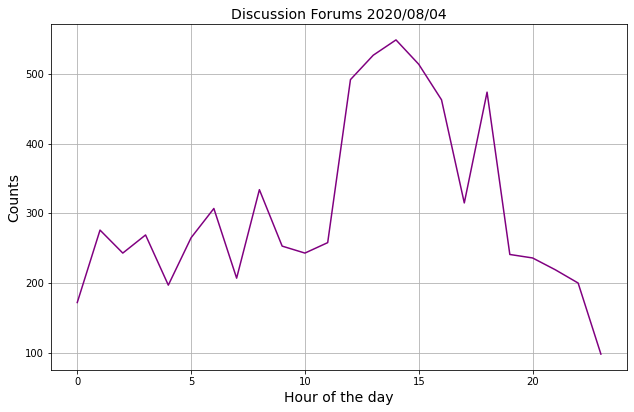

In [2]:
# Plot hour of day for access to discussion forum
plt.clf()
plt.figure(figsize=(10, 6))
plt.axes([0.15, 0.12, 0.8, 0.8])
plt.grid(True)
dr = df1.groupby('hour')['path'].count()
plt.plot(dr.index.values, dr.values, '-', color='purple')
plt.title('Discussion Forums 2020/08/04', size=14)
plt.xlabel("Hour of the day", size=14)
_ = plt.ylabel("Counts", size=14)

This is a weekday. We have higher usage in the afternoon, at around 2pm to 5pm.

## Do we know which discussion learners have accessed? 

We divide the discussion forums into discussion homepage, all, forums, and week1-7 sections.

<Figure size 432x288 with 0 Axes>

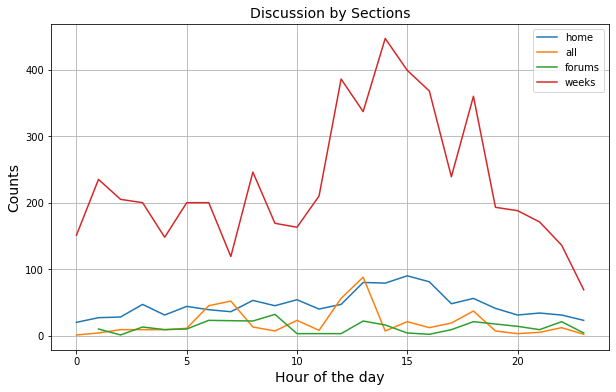

In [3]:
# Identify sections from path
dx = df1.loc[:, ['path', 'hour']]

for section in 'all', 'forums', 'weeks':
    idx = dx.path.apply(lambda i: section in i)
    dx.loc[idx, 'section'] = section

dx.loc[dx.section.isnull(), 'section'] = 'home'

# Plot frequency of each section
plt.clf()
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plt.grid(True)
plt.title('Discussion by Sections', size=14)
plt.xlabel("Hour of the day", size=14)
plt.ylabel("Counts", size=14)

dr = dx.groupby(['section', 'hour'])['path'].count()
section = ['home', 'all', 'forums', 'weeks']
for s in section:
    plt.plot(dr[s].index.values, dr[s].values, '-', marker='', linewidth=1.5, label=s)
    plt.legend(loc='best')

The plot shows the hourly activity for each section.

<Figure size 432x288 with 0 Axes>

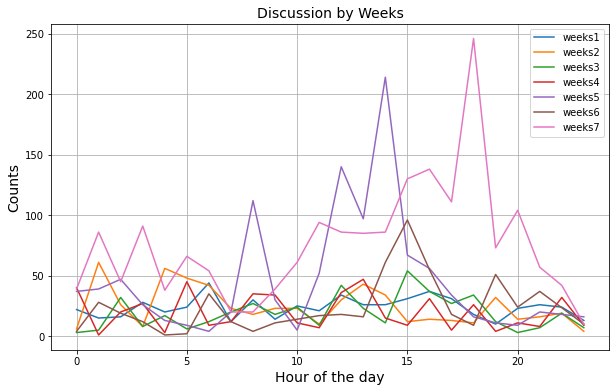

In [4]:
# Include number of week in the data
dx = df1.loc[:, ['path', 'hour']]

for section in 'all', 'forums', 'weeks':
    if section == 'weeks':
        idx = dx.path.apply(lambda i: section in i)
        dx.loc[idx, 'section'] = dx.loc[idx, 'path'].apply(lambda x: ''.join(x[1:3]))
    else:        
        idx = dx.path.apply(lambda i: section in i)
        dx.loc[idx, 'section'] = section

# np.unique(dx[dx.section.isnull()].path)
dx.loc[dx.section.isnull(), 'section'] = 'home'

# Plot frequency for each section
plt.clf()
plt.figure(figsize=(10, 6))
plt.axes()
plt.grid(True)
plt.title('Discussion by Weeks', size=14)
plt.xlabel("Hour of the day", size=14)
plt.ylabel("Counts", size=14)

dr = dx.groupby(['section', 'hour'])['path'].count()
section = []
section.extend([''.join('weeks%d' % (j+1)) for j in range(7)])
for s in section:
    plt.plot(dr[s].index.values, dr[s].values, '-', marker='', linewidth=1.5, label=s)
    plt.legend(loc='best')

The plot shows the hourly activity for each week discussion. It can be helpful to know what time of the day students were active and which week of the topic students were stuggle the most.

## Are we able to see any additional details about forum access? (e.g., Can we tell if someone has clicked on a button, responded to another user, created their own discussion thread, etc?) 

The sections can be further divided into threads, comments, and replies. The context of threads and answers can be found in discussion-related tables (discussion_course_forums, discussion_questions, and discussion_answers).

Below we show the frequency of threads, comments, and replies within each section in a single day.

In [5]:
# Add a column called part to identify the event is either threads, comments, or answers
def f(x):
    if 'comments' in x:
        return 'comments'
    elif 'replies' in x:
        return 'replies'
    elif 'threads' in x:
        return 'threads'
    else:
        return 'posts'
dx['part'] = dx.path.map(f)
dr = dx.groupby(['section', 'part']).agg({'path': 'count'})
dr['cnt_perc'] = dr.groupby('section').apply(lambda x: round(x / float(x.sum()), 2))
dr.rename(columns={'path': 'cnt'}, inplace=True)

dd = dr.reset_index().pivot(index='section', columns='part', values=['cnt', 'cnt_perc'])
dd

cnt                         cnt_perc                      
part    comments   posts replies threads comments posts replies threads
section                                                                
all         20.0   155.0    51.0   234.0     0.04  0.34    0.11    0.51
forums       NaN   167.0     NaN    81.0      NaN  0.67     NaN    0.33
home         NaN  1105.0     NaN     NaN      NaN  1.00     NaN     NaN
weeks1       NaN   426.0     NaN   144.0      NaN  0.75     NaN    0.25
weeks2       NaN   401.0     NaN   185.0      NaN  0.68     NaN    0.32
weeks3       NaN   302.0     NaN   155.0      NaN  0.66     NaN    0.34
weeks4       NaN   307.0     NaN   170.0      NaN  0.64     NaN    0.36
weeks5       1.0   616.0     7.0   450.0     0.00  0.57    0.01    0.42
weeks6       NaN   331.0     NaN   223.0      NaN  0.60     NaN    0.40
weeks7       2.0   977.0     1.0   841.0     0.00  0.54    0.00    0.46

The NaN means the part isn't found in its corresponding section. The percentage of counts computes the proportion of events within each section. Section "all" and "weeks7" have the most threads activity among the 10 sections.